In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ase.build import mx2
from abtem import *
from abtem.structures import orthogonalize_cell

# Is Nyquist sampling good enough?

In [2]:
atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(1, 1, 1), vacuum=None)

repetitions = (3, 2, 1)

atoms = orthogonalize_cell(atoms)

atoms *= repetitions

atoms.center(vacuum=2, axis=2)

In [3]:
probe = Probe(energy=80e3, semiangle_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)

potential = Potential(atoms, sampling=.02, projection='finite', slice_thickness=1, parametrization='kirkland')

detector = AnnularDetector(inner = 50, outer=200)

In [4]:
end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan_nyquist = GridScan(start=[0, 0], end=end, sampling=probe.ctf.nyquist_sampling * .9, endpoint=False)

gridscan_fine = gridscan_nyquist.copy()
gridscan_fine.sampling = (gridscan_nyquist.sampling[0] / 4, gridscan_nyquist.sampling[1] / 4)

measurements_nyquist = probe.scan(gridscan_nyquist, [detector], potential, pbar=False)[detector]
measurements_fine = probe.scan(gridscan_fine, [detector], potential, pbar=False)[detector]

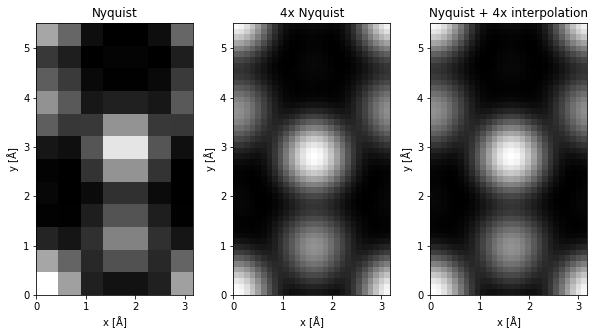

In [7]:
interpolated = measurements_nyquist.interpolate(gridscan_fine.sampling, kind='quintic')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

measurements_nyquist.show(ax=ax1, title='Nyquist')
measurements_fine.show(ax=ax2, title='4x Nyquist')
interpolated.show(ax=ax3, title='Nyquist + 4x interpolation');

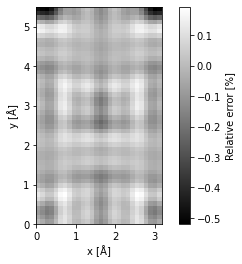

In [9]:
relative_error = measurements_fine.copy()
relative_error.array[:] = (interpolated.array - measurements_fine.array) / interpolated.array.max() * 100.

ax, im = relative_error.show()

plt.colorbar(im, label='Relative error [%]');